In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
from scipy import stats
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_palette('colorblind'); sns.set_color_codes()

#### Code 4.1

/home/osvaldo/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


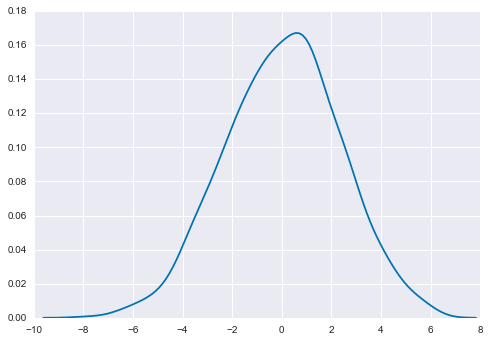

In [2]:
pos = np.random.uniform(-1, 1, size=(16, 1000)).sum(0)
sns.kdeplot(pos);

#### Code 4.2 and 4.3

/home/osvaldo/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


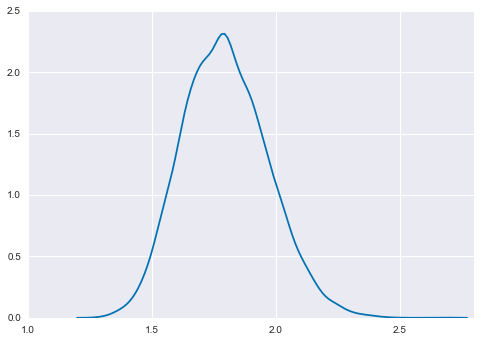

In [3]:
pos = np.random.uniform(1, 1.1, size=(12, 10000)).prod(0)
sns.kdeplot(pos);

#### Code 4.4

/home/osvaldo/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


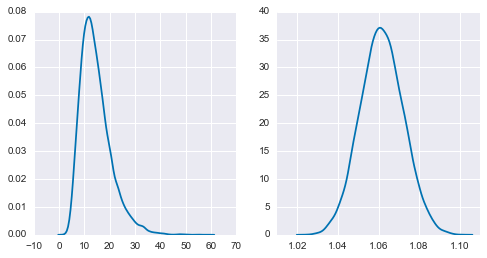

In [4]:
big = np.random.uniform(1, 1.5, size=(12, 10000)).prod(0)
small = np.random.uniform(1, 1.01, size=(12, 10000)).prod(0)
_, ax = plt.subplots(1,2, figsize=(8,4))
sns.kdeplot(big, ax=ax[0])
sns.kdeplot(small, ax=ax[1]);

#### Code 4.5

/home/osvaldo/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


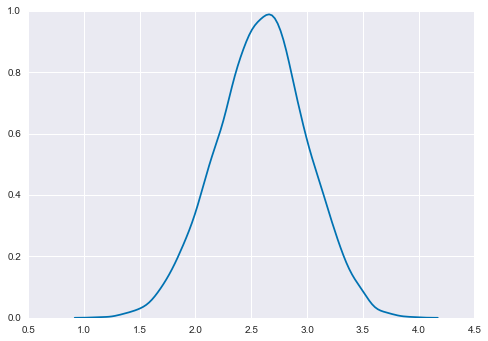

In [5]:
log_big = np.log(np.random.uniform(1, 1.5, size=(12, 10000)).prod(0))
sns.kdeplot(log_big);

#### Code 4.6

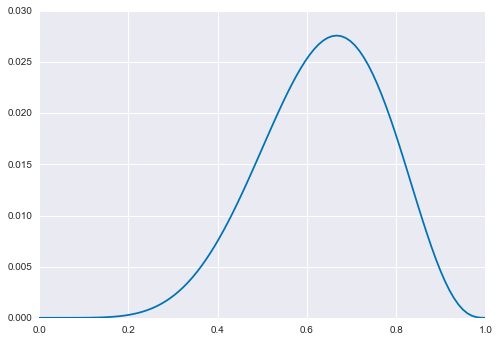

In [6]:
w, n = 6, 9
p_grid = np.linspace(0, 1, 100)
posterior = stats.binom.pmf(k=w, n=n, p=p_grid) * stats.uniform.pdf(p_grid, 0, 1)
posterior = posterior / (posterior).sum()
plt.plot(p_grid, posterior);

#### Code 4.7 and 4.8

In [7]:
d = pd.read_csv('Data/Howell1.csv', sep=';', header=0)
d.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0


#### Code 4.9

In [8]:
d.height.head()

0    151.765
1    139.700
2    136.525
3    156.845
4    145.415
Name: height, dtype: float64

#### Code 4.10

In [9]:
d2 = d[d.age >= 18]

#### Code 4.11

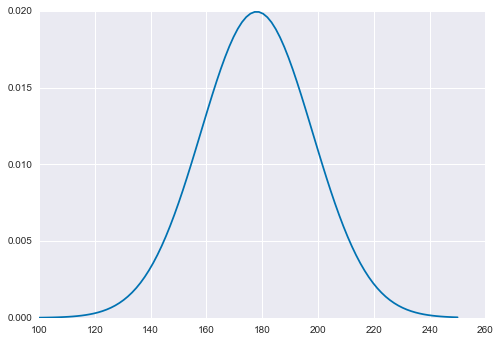

In [10]:
x = np.linspace(100, 250, 100)
plt.plot(x, stats.norm.pdf(x, 178, 20));

#### Code 4.12

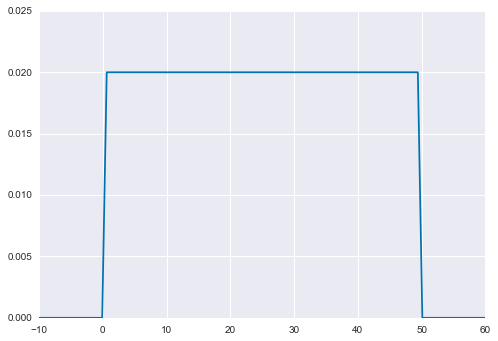

In [11]:
x = np.linspace(-10, 60, 100)
plt.plot(x, stats.uniform.pdf(x, 0, 50));

#### Code 4.13

/home/osvaldo/anaconda3/lib/python3.5/site-packages/scipy/stats/_continuous_distns.py:127: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return self._random_state.standard_normal(self._size)
/home/osvaldo/anaconda3/lib/python3.5/site-packages/scipy/stats/_continuous_distns.py:4894: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return self._random_state.uniform(0.0, 1.0, self._size)
/home/osvaldo/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


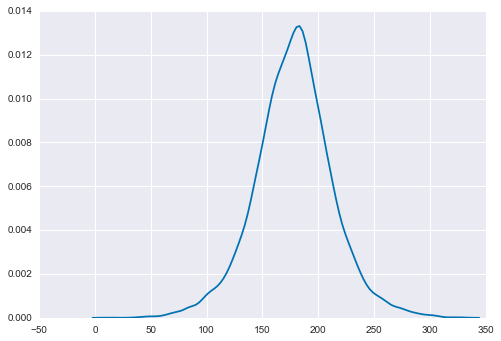

In [12]:
n_samples = 1e4
sample_mu = stats.norm.rvs(loc=178, scale=20, size=n_samples)
sample_sigma = stats.uniform.rvs(loc=0, scale=50, size=n_samples)
prior_h = stats.norm.rvs(loc=sample_mu, scale=sample_sigma)
sns.kdeplot(prior_h);

#### Code 4.14

In [13]:
post = np.mgrid[140:160:0.1, 4:9:0.1].reshape(2,-1).T

likelihood = [sum(stats.norm.logpdf(d2.height, loc=post[:,0][i], scale=post[:,1][i])) for i in range(len(post))]

post_prod = likelihood + stats.norm.logpdf(post[:,0], loc=178, scale=20) + stats.uniform.logpdf(post[:,1], loc=0, scale=50)
post_prob = np.exp(post_prod - max(post_prod))

#### Code 4.15 and 4.16

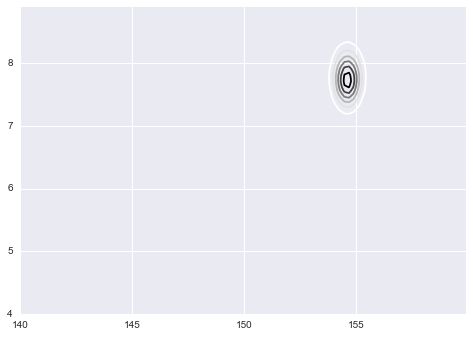

In [14]:
xi = np.linspace(post[:,0].min(), post[:,0].max(), 100)
yi = np.linspace(post[:,1].min(), post[:,1].max(), 100)
zi = griddata((post[:,0], post[:,1]), post_prob, (xi[None,:], yi[:,None]))

plt.contour(xi, yi, zi);

#### Code 4.17 and 4.18

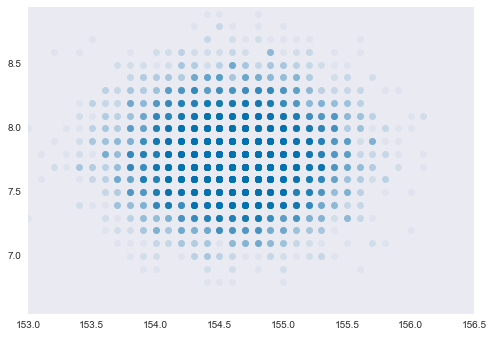

In [15]:
sample_rows = np.random.choice(np.arange(len(post)), size=10000, replace=True, 
                               p=(post_prob/post_prob.sum()))
sample_mu = post[:,0][sample_rows]
sample_sigma = post[:,1][sample_rows]

plt.plot(sample_mu, sample_sigma, 'o', alpha=0.05)
plt.axis('equal');
plt.grid(False)

#### Code 4.19

/home/osvaldo/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


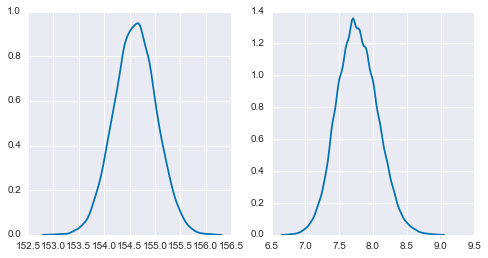

In [16]:
_, ax = plt.subplots(1,2, figsize=(8,4))
sns.kdeplot(sample_mu, ax=ax[0])
sns.kdeplot(sample_sigma, ax=ax[1]);

#### Code 4.20

In [17]:
pm.hpd(sample_mu), pm.hpd(sample_sigma)

(array([ 153.8,  155.4]), array([ 7.3,  8.4]))

#### Code 4.21 and  4.22

In [18]:
d3 = np.random.choice(d2.height, 20)
post2 = np.mgrid[150:170:0.1, 4:20:0.1].reshape(2,-1).T

likelihood2 = [sum(stats.norm.logpdf(d3, loc=post[:,0][i], scale=post[:,1][i])) for i in range(len(post))]

post_prod2 = likelihood + stats.norm.logpdf(post[:,0], loc=178, scale=20) + stats.uniform.logpdf(post[:,1], loc=0, scale=50)
post_prob2 = np.exp(post_prod - max(post_prod))

sample_rows2 = np.random.choice(np.arange(len(post)), size=10000, replace=True, 
                               p=(post_prob/post_prob.sum()))
sample_mu2 = post[:,0][sample_rows]
sample_sigma2 = post[:,1][sample_rows]

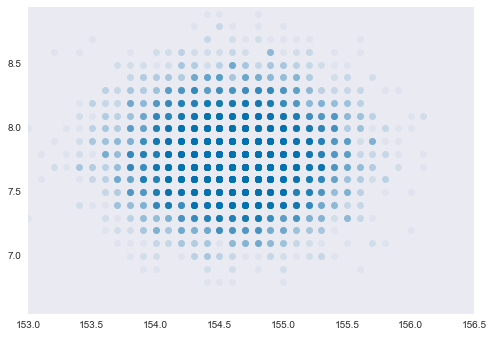

In [19]:
plt.plot(sample_mu2, sample_sigma2, 'o', alpha=0.05)
plt.axis('equal');
plt.grid(False)

#### Code 4.23

/home/osvaldo/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


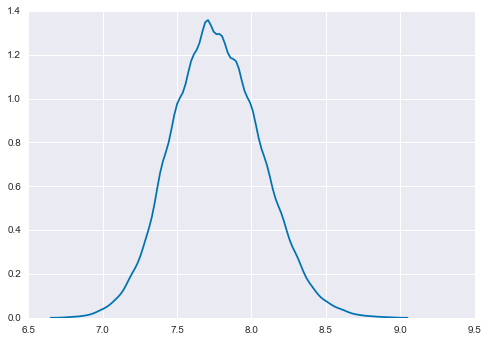

In [20]:
sns.kdeplot(sample_sigma2);

#### Code 4.24

We are repeating code 4.7, 4.8 and 4.10

In [21]:
d = pd.read_csv('Data/Howell1.csv', sep=';', header=0)
d2 = d[d.age >= 18]

#### Code 4.25

In [22]:
with pm.Model() as m4_1:
    mu = pm.Normal('mu', mu=178, sd=20)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d2.height)

#### Code 4.26

We could use a quadratic approximation like McElreath does in his book and we did in code 2.6. But Using PyMC3 is really simple to just sample from the model using a "sampler method". Most common sampler methods are members of the Markov Chain Monte Carlo Method (MCMC) family (for details read Section 2.4.3 and Chapter 8 of Statistical Rethinking).

PyMC3 comes with various sampler. Some sampler are more suited than others for certain type of variable (and/or problems). For now we are going to let PyMC3 choose the sampler for us. PyMC3 also tries to provide a reasonable starting point for the simulation. By default PyMC3 uses ADVI `init='advi'`, other alternatives are using a MAP (maximum a posteriori) (`init='map'`), a combination of MAP and ADVI (`init='advi_map'`) or NUTS (`init='nuts'`).

You can read more details of PyMC3 [here](http://pymc-devs.github.io/pymc3/notebooks/getting_started.html)

In [23]:
with m4_1:
    trace_4_1 = pm.sample(1000, init='advi_map')

100%|██████████| 1000/1000 [00:02<00:00, 450.66it/s]

Optimization terminated successfully.
         Current function value: 1226.038336
         Iterations: 10
         Function evaluations: 18
         Gradient evaluations: 18


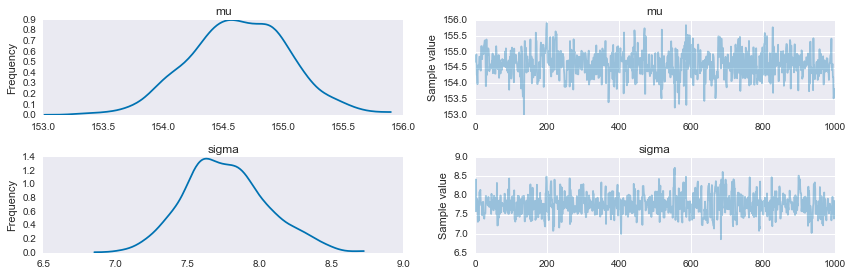

In [24]:
pm.traceplot(trace_4_1); # this function let you check the samples values

#### Code 4.27

Notice that comapred to the table in the book we have an extra column, "mc_error". Since we are sampling from the posterior, there is an error introducing by the sampling process. This error can be reduced by taking more samples.

In [25]:
pm.df_summary(trace_4_1)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
mu,154.627309,0.419391,0.017761,153.788955,155.422415
sigma,7.764843,0.286223,0.010720,7.186985,8.305561


#### Code 4.28

In [26]:
with pm.Model() as m4_1:
    mu = pm.Normal('mu', mu=178, sd=20, testval=d2.height.mean())
    sigma = pm.Uniform('sigma', lower=0, upper=50, testval=d2.height.std())
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d2.height)
    trace_4_1 = pm.sample(1000)

100%|██████████| 1000/1000 [00:02<00:00, 544.86it/s]


#### Code 4.29

In [27]:
with pm.Model() as m4_2:
    mu = pm.Normal('mu', mu=178, sd=0.1)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d2.height)
    trace_4_2 = pm.sample(1000)

100%|██████████| 1000/1000 [00:02<00:00, 461.80it/s]


In [28]:
pm.df_summary(trace_4_2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
mu,177.866878,0.092058,0.003854,177.694333,178.047434
sigma,24.631714,0.894325,0.038620,22.936251,26.266196


#### Code 4.30

For some computations could be nice to have the trace turned into a DataFrame, this can be donde using the "trace_to_dataframe" function

In [29]:
trace_df = pm.trace_to_dataframe(trace_4_1)
trace_df.cov()

,sigma,mu
sigma,0.091564,-0.009792
mu,-0.009792,0.147048


#### Code 4.31

In [30]:
np.diag(trace_df.cov())

array([ 0.09156366,  0.14704806])

In [31]:
trace_df.corr()

,sigma,mu
sigma,1.000000,-0.084386
mu,-0.084386,1.000000


#### Code 4.32

We did not use the quadratic approximation, instead we use a MCMC method to sample from the posterior. Thus, we already have samples. We can do something like

In [32]:
trace_df.head()

,sigma,mu
0,7.444628,155.132537
1,7.444628,155.132537
2,7.660443,154.227222
3,7.736934,154.279097
4,7.754643,154.787486


Or directly from the trace (we are getting the first ten samples of _sigma_)

In [33]:
trace_4_1['sigma'][:10]

array([ 7.4446282 ,  7.4446282 ,  7.66044318,  7.73693383,  7.75464323,
        7.75464323,  7.8841409 ,  7.97740216,  7.95379299,  7.66523011])

#### Code 4.33

In our case, this is the same we did in the code 4.27

In [34]:
pm.df_summary(trace_4_1)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
mu,154.612225,0.383277,0.015250,153.868838,155.339507
sigma,7.785502,0.302444,0.011699,7.265589,8.464782


#### Code 4.34

In [35]:
stats.multivariate_normal.rvs(mean=trace_df.mean(), cov=trace_df.cov(), size=10)

array([[   7.66522374,  154.30070288],
       [   7.5577399 ,  153.92399077],
       [   7.62319312,  154.56917953],
       [   7.50718468,  155.18171579],
       [   7.70232543,  154.70398223],
       [   7.83609629,  154.27251597],
       [   7.66778082,  154.50364724],
       [   7.8609695 ,  154.60516637],
       [   7.98989833,  154.91921685],
       [   7.47119016,  154.49622889]])

#### Code 4.35 and 4.36

Instead of sampling from a normal and then exponentiating to ensure sigma is positive, we can use the lognormal distribution for the same result. The Lognormal distribution is parametrized in terms of $\tau$ (tau) the precision and not the standard deviation, where: 

$$tau=\frac{1}{sd^2}$$

The normal distribution can also be parametrized in terms of the precision (tau). Given that the conversion between both parametrization is done right, which one to use is only a matter of convenience. 

In [36]:
with pm.Model() as m4_1_logsigma:
    mu = pm.Normal('mu', mu=178, sd=20)
    sigma = pm.Lognormal('sigma', mu=2, tau=0.01)
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d2.height)
    trace_4_1_logsigma = pm.sample(2000)

100%|██████████| 2000/2000 [00:02<00:00, 698.86it/s] 


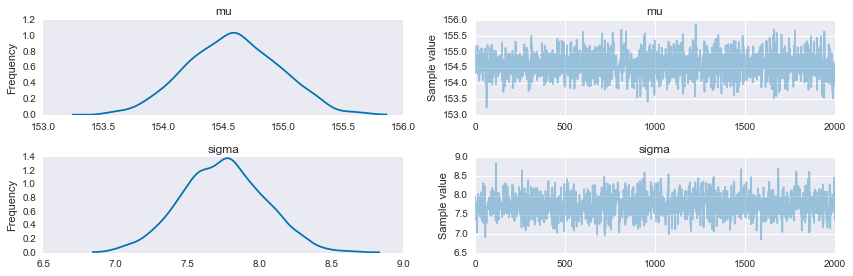

In [37]:
pm.traceplot(trace_4_1_logsigma);

#### Code 4.37

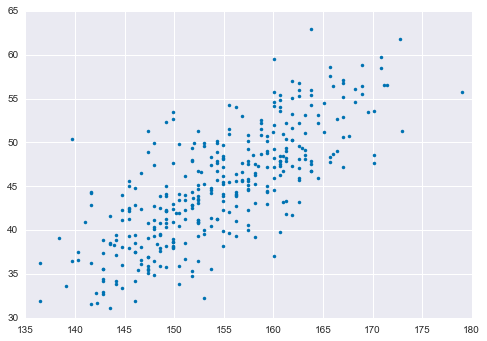

In [38]:
plt.plot(d2.height, d2.weight, '.');

#### Code 4.38 and 4.39

Notice that the variable mu is defined as alpha + beta * d2.weight in a single line. If we want the trace to containt mu we can write as a deterministic varible. The computating will be exactly the same. The only diference is that mu will be accesible in the trace.

In [39]:
with pm.Model() as m4_3:
    alpha = pm.Normal('alpha', mu=178, sd=100)
    beta = pm.Normal('beta', mu=0, sd=10)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    mu = alpha + beta * d2.weight
    #mu = pm.Deterministic('mu' alpha + beta * d2.weight) # try uncomenting this line and comenting the above line
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d2.height)
    trace_4_3 = pm.sample(2000)

100%|██████████| 2000/2000 [00:13<00:00, 151.61it/s]


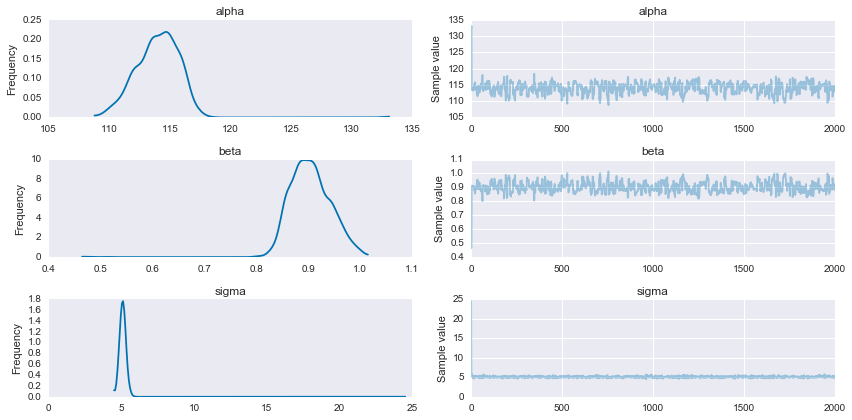

In [40]:
pm.traceplot(trace_4_3);

Another alternative is to write mu inside the likelihood and not as a separate line.

    height = pm.Normal('height', mu=alpha + beta * d2.weight, sd=sigma, observed=d2.height)
    
Using PyMC3 there is not too much reason to do this. I personally think that defining mu in a separate lines improves readability.

#### Code 4.40

In [41]:
pm.df_summary(trace_4_3, alpha=0.11).round(2)

,mean,sd,mc_error,hpd_5.5,hpd_94.5
alpha,113.99,1.83,0.09,111.26,116.44
beta,0.90,0.04,0.00,0.85,0.96
sigma,5.11,0.48,0.01,4.77,5.38


#### Code 4.41

In [42]:
trace_df = pm.trace_to_dataframe(trace_4_3)
trace_df.corr().round(2)

,alpha,sigma,beta
alpha,1.00,0.24,-0.99
sigma,0.24,1.00,-0.25
beta,-0.99,-0.25,1.00


#### Code 4.42

In [43]:
d2['weight_c'] = d2.weight - d2.weight.mean()

/home/osvaldo/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


#### Code 4.43

In [44]:
with pm.Model() as m4_4:
    alpha = pm.Normal('alpha', mu=178, sd=100)
    beta = pm.Normal('beta', mu=0, sd=10)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    mu = alpha + beta * d2.weight_c
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d2.height)
    trace_4_4 = pm.sample(2000)

100%|██████████| 2000/2000 [00:03<00:00, 514.56it/s]


#### Code 4.44

In [45]:
pm.df_summary(trace_4_4, alpha=.11).round(2)

,mean,sd,mc_error,hpd_5.5,hpd_94.5
alpha,154.59,0.27,0.01,154.16,155.01
beta,0.91,0.04,0.00,0.84,0.98
sigma,5.17,1.13,0.07,4.81,5.40


#### Code 4.45

Instead of using the MAP, we are going to use the mean of the posterior 

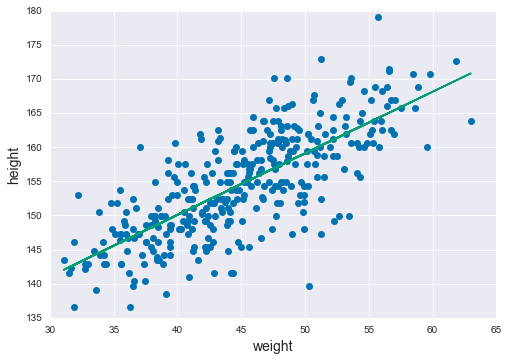

In [46]:
plt.plot(d2.weight, d2.height, 'o')
plt.plot(d2.weight, trace_4_3['alpha'].mean() + trace_4_3['beta'].mean() * d2.weight)
plt.xlabel(d2.columns[1], fontsize=14)
plt.ylabel(d2.columns[0], fontsize=14);

#### Code 4.46 and 4.47

In [47]:
pm.trace_to_dataframe(trace_4_4)[:5]

,alpha,sigma,beta
0,154.806862,25.076774,0.947359
1,154.806862,25.076774,0.947359
2,154.717733,23.981851,0.928747
3,154.749077,23.649780,0.948027
4,154.598954,23.946047,0.973834


#### Code 4.48

In [48]:
N = [10, 50, 150, 352][0]
with pm.Model() as m_N:
    alpha = pm.Normal('alpha', mu=178, sd=100)
    beta = pm.Normal('beta', mu=0, sd=10)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    mu = pm.Deterministic('mu', alpha + beta * d2.weight[:N])
    height_hat = pm.Normal('height_hat', mu=mu, sd=sigma, observed=d2.height[:N])
    trace_N = pm.sample(2000)

100%|██████████| 2000/2000 [00:12<00:00, 157.38it/s]


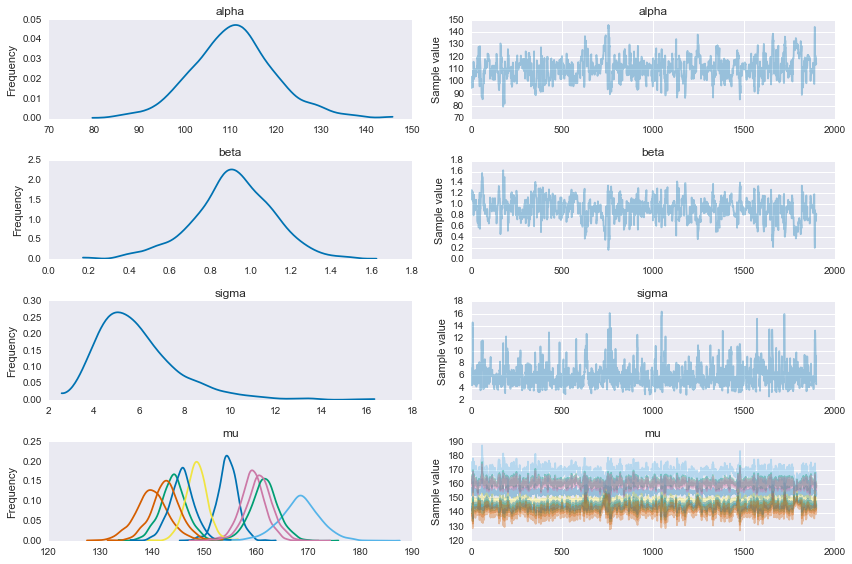

In [49]:
chain_N = trace_N[100:]
pm.traceplot(chain_N);

#### Code 4.49

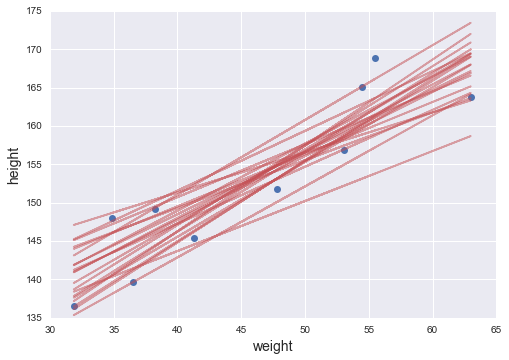

In [50]:
plt.plot(d2.weight[:N], d2.height[:N], 'bo')
for _ in range(0, 20):
    idx = np.random.randint(len(chain_N))
    plt.plot(d2.weight[:N], chain_N['alpha'][idx] + chain_N['beta'][idx] * d2.weight[:N], 'r-', alpha=0.5)
plt.xlabel(d2.columns[1], fontsize=14)
plt.ylabel(d2.columns[0], fontsize=14);

Alternative we can directly use the deterministic mu variable

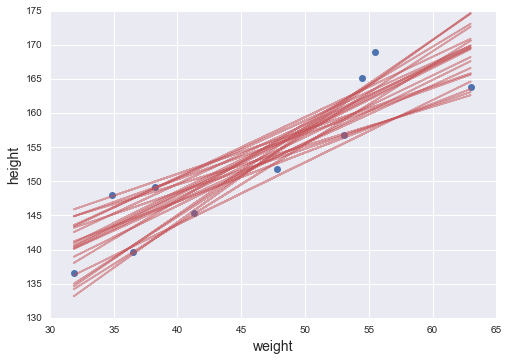

In [51]:
plt.plot(d2.weight[:N], d2.height[:N], 'bo')
for _ in range(0, 20):
    idx = np.random.randint(len(chain_N))
    plt.plot(d2.weight[:N], chain_N['mu'][idx], 'r-', alpha=0.5)
plt.xlabel(d2.columns[1], fontsize=14)
plt.ylabel(d2.columns[0], fontsize=14);

#### Code 4.50 and 4.51

/home/osvaldo/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


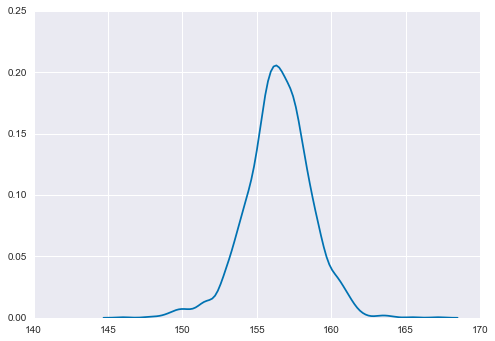

In [52]:
mu_at_50 = chain_N['alpha'] + chain_N['beta'] * 50
sns.kdeplot(mu_at_50);

#### Code 4.52

In [53]:
pm.hpd(mu_at_50, alpha=.11)

array([ 152.91790443,  159.60872378])

#### Code 4.53

Using PyMC3, we do not need to compute anything else. By defining a deterministic variable mu in the model, we add that variable to the trace. Thus we get a matrix with row samples from the posterior and columns values of weights. We can access this matrix directly from the trace or turn it into a DataFrame, it all depends on what we need.

In [54]:
df_trace_N = pm.trace_to_dataframe(chain_N).filter(regex=('mu.*'))
df_trace_N.head()

,mu__0,mu__1,mu__2,mu__3,mu__4,mu__5,mu__6,mu__7,mu__8,mu__9
0,157.475644,144.390545,139.058367,163.494790,149.918999,174.976964,146.418735,166.308086,142.525918,165.163140
1,152.292320,139.561053,134.373061,158.148703,144.940013,169.320391,141.534399,160.885926,137.746847,159.771940
2,154.857539,140.607172,134.800147,161.412708,146.627952,173.917405,142.815978,164.476537,138.576494,163.229629
3,156.753132,142.438591,136.605416,163.337821,148.486485,175.898831,144.657345,166.415447,140.398769,165.162925
4,153.174626,140.842788,135.817564,158.847272,146.052989,169.668460,142.754223,161.498617,139.085501,160.419581


#### Code 4.54 and 4.58

We are doing _manually_, what in thebook is done using the ```link``` function. In the book on code 4.58 the following operations are performed _manually_.

In [55]:
weigth_seq = np.arange(25, 71)
# Given that we have a lot of samples we can use less of them for plotting (or we can use all!)
chain_N_thinned = chain_N[::10]
mu_pred = np.zeros((len(weigth_seq), len(chain_N_thinned)))
for i, w in enumerate(weigth_seq):
    mu_pred[i] = chain_N_thinned['alpha'] + chain_N_thinned['beta'] * w

#### Code 4.55

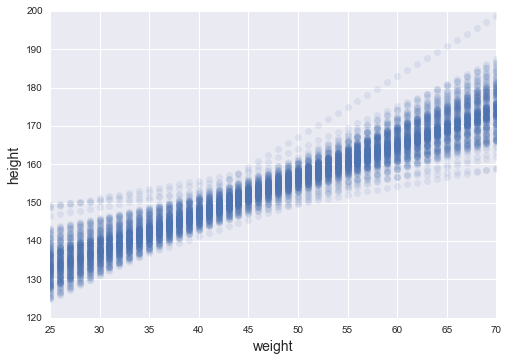

In [56]:
plt.plot(weigth_seq, mu_pred, 'bo', alpha=0.1)
plt.xlabel('weight', fontsize=14)
plt.ylabel('height', fontsize=14);

#### Code 4.56

In [57]:
mu_mean = mu_pred.mean(1)
mu_hpd = pm.hpd(mu_pred.T, alpha=.11)

#### Code 4.57

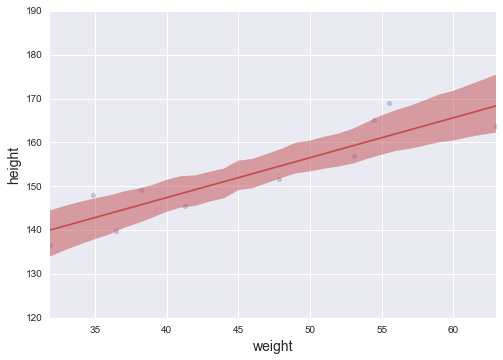

In [58]:
plt.scatter(d2.weight[:N], d2.height[:N], c='b', alpha=0.3)
plt.plot(weigth_seq, mu_mean, 'r')
plt.fill_between(weigth_seq, mu_hpd[:,0], mu_hpd[:,1], color='r', alpha=0.5)
plt.xlabel('weight', fontsize=14)
plt.ylabel('height', fontsize=14)
plt.xlim(d2.weight[:N].min(), d2.weight[:N].max());

#### Code 4.59

Now we are going to use ```sample_ppc()``` from PyCM3. This function give us posterior predictive samples, that is for each value of the input variable we get the a sample (from the posterior) of the output variable. Thus in the following example the shape of height_pred['height_hat'].shape is (200, 352)

In [59]:
height_pred = pm.sample_ppc(chain_N, 200, m_N)

100%|██████████| 200/200 [00:03<00:00, 59.42it/s]


#### Code 4.60

In [60]:
height_pred_hpd = pm.hpd(height_pred['height_hat'])

#### Code 4.61
```sample_ppc``` returns values corresponding to the input values (weights in this example). Because the weights are not ordered if we use them with the ```fill_between``` function we will get a mess. For that reason in the following cell we order the weights and the predicted heights

In [61]:
idx = np.argsort(d2.weight.values[:N])
d2_weight_ord = d2.weight.values[:N][idx]
height_pred_hpd = height_pred_hpd[idx]

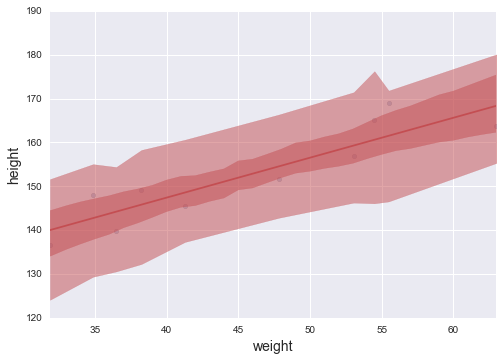

In [62]:
plt.scatter(d2.weight[:N], d2.height[:N], c='b', alpha=0.3)
plt.plot(weigth_seq, mu_mean, 'r')
plt.fill_between(weigth_seq, mu_hpd[:,0], mu_hpd[:,1], color='r', alpha=0.5)
plt.fill_between(d2_weight_ord, height_pred_hpd[:,0], height_pred_hpd[:,1], color='r', alpha=0.5)
plt.xlabel('weight', fontsize=14)
plt.ylabel('height', fontsize=14)
plt.xlim(d2.weight[:N].min(), d2.weight[:N].max());

#### Code 4.62

Change the number of samples used in 4.59 (200) to other values. Because we are getting samples at the input values the jaggedness of this plot is larger than the one in the book.

#### Code 4.63

Now we are going to generate heights from the posterior _manually_, instead of restricting to the input values we are going to pass an array of equally spaced weights values ```weight_seg```.

In [63]:
weigth_seq = np.arange(25, 71)
post_samples = []
for _ in range(1000): # number of samples from the posterior
    i = np.random.randint(len(chain_N))
    mu_pred = chain_N['alpha'][i] + chain_N['beta'][i] * weigth_seq
    sigma_pred = chain_N['sigma'][i]
    post_samples.append(np.random.normal(mu_pred, sigma_pred))

In [64]:
post_samples_hpd = pm.hpd(np.array(post_samples))

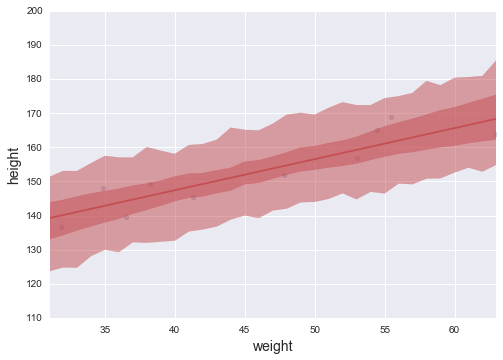

In [65]:
plt.scatter(d2.weight[:N], d2.height[:N], c='b', alpha=0.3)
plt.plot(weigth_seq, mu_mean, 'r')
plt.fill_between(weigth_seq, mu_hpd[:,0], mu_hpd[:,1], color='r', alpha=0.5)
plt.fill_between(weigth_seq, post_samples_hpd[:,0], post_samples_hpd[:,1], color='r', alpha=0.5)
plt.xlabel('weight', fontsize=14)
plt.ylabel('height', fontsize=14)
plt.xlim(d2.weight.min(), d2.weight.max());

#### Code 4.64

We have already loaded this dataset, check code 4.7 and 4.8.

In [66]:
d.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0


#### Code 4.65

In [67]:
d.weight_std = (d.weight - d.weight.mean()) / d.weight.std()
d.weight_std2 = d.weight_std**2

#### Code 4.66

In [68]:
with pm.Model() as m_4_5:
    alpha = pm.Normal('alpha', mu=178, sd=100)
    beta = pm.Normal('beta', mu=0, sd=10, shape=2)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    mu = pm.Deterministic('mu', alpha + beta[0] * d.weight_std + beta[1] * d.weight_std2)
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d.height)
    trace_4_5 = pm.sample(2000)

100%|██████████| 2000/2000 [00:06<00:00, 297.37it/s]


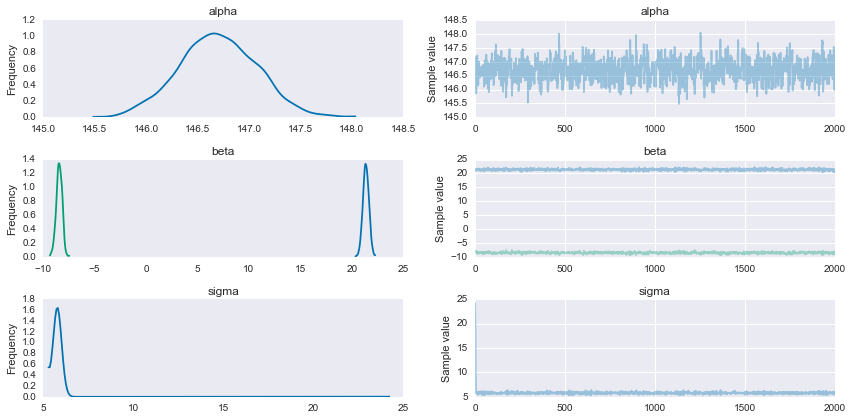

In [69]:
varnames = ['alpha', 'beta', 'sigma']
pm.traceplot(trace_4_5, varnames);

#### Code 4.67

In [70]:
pm.df_summary(trace_4_5, varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha,146.697888,0.376639,0.013636,145.984137,147.451257
beta__0,21.375049,0.291653,0.008518,20.804165,21.949193
beta__1,-8.438456,0.286035,0.011103,-9.016171,-7.921947
sigma,5.821619,0.765997,0.035665,5.445126,6.143187


#### Code 4.68

In [71]:
mu_pred = trace_4_5['mu']
idx = np.argsort(d.weight_std)
mu_hpd = pm.hpd(mu_pred, alpha=.11)[idx]

height_pred = pm.sample_ppc(trace_4_5, 200, m_4_5)
height_pred_hpd = pm.hpd(height_pred['height'], alpha=.11)[idx]

100%|██████████| 200/200 [00:09<00:00, 20.84it/s]


#### Code 4.69

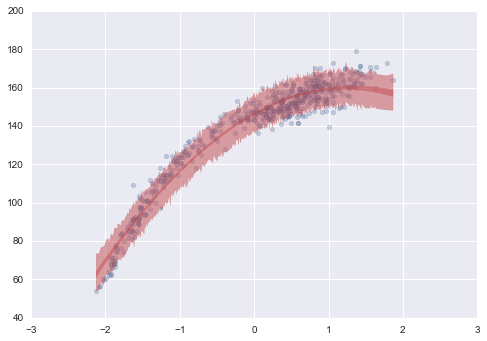

In [72]:
plt.scatter(d.weight_std, d.height, c='b', alpha=0.3)
plt.fill_between(d.weight_std[idx], mu_hpd[:,0], mu_hpd[:,1], color='r', alpha=0.5);
plt.fill_between(d.weight_std[idx], height_pred_hpd[:,0], height_pred_hpd[:,1], color='r', alpha=0.5);

#### Code 4.70

We will stack the weights to get a 2D array, these simplifies wrriting a model. Now we can compute the dot product between beta and the 2D-array

In [73]:
weight_m = np.vstack((d.weight_std, d.weight_std**2, d.weight_std**3))

In [74]:
with pm.Model() as m_4_6:
    alpha = pm.Normal('alpha', mu=178, sd=100)
    beta = pm.Normal('beta', mu=0, sd=10, shape=3)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    mu = pm.Deterministic('mu', alpha + pm.math.dot(beta, weight_m))
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d.height)
    trace_4_6 = pm.sample(2000)

100%|██████████| 2000/2000 [00:09<00:00, 200.89it/s]


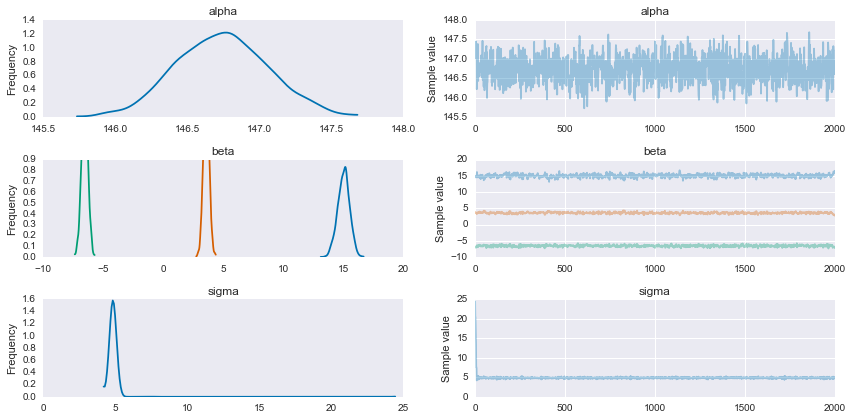

In [75]:
pm.traceplot(trace_4_6, varnames);

#### Code 4.71 and 4.72

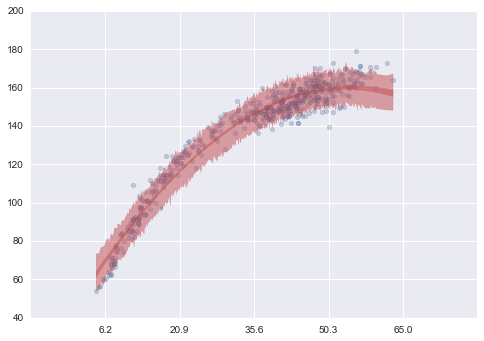

In [76]:
plt.scatter(d.weight_std, d.height, c='b', alpha=0.3)
plt.fill_between(d.weight_std[idx], mu_hpd[:,0], mu_hpd[:,1], color='r', alpha=0.5);
plt.fill_between(d.weight_std[idx], height_pred_hpd[:,0], height_pred_hpd[:,1], color='r', alpha=0.5)

at = np.arange(-2, 3)
plt.xticks(at, np.round(at * d.weight.std() + d.weight.mean(), 1));

In [77]:
import sys, IPython, scipy, matplotlib, platform
print("This notebook was createad on a computer %s running %s and using:\nPython %s\nIPython %s\nPyMC3 %s\nNumPy %s\nPandas %s\nSciPy %s\nMatplotlib %s\nSeaborn %s\n" % (platform.machine(), ' '.join(platform.linux_distribution()[:2]), sys.version[:5], IPython.__version__, pm.__version__, np.__version__, pd.__version__, scipy.__version__, matplotlib.__version__, sns.__version__))

This notebook was createad on a computer x86_64 running debian stretch/sid and using:
Python 3.5.2
IPython 5.0.0
PyMC3 3.0.rc4
NumPy 1.11.2
Pandas 0.19.1
SciPy 0.18.1
Matplotlib 1.5.3
Seaborn 0.7.1

